We can use mne to systematically go through the channels and find events marked by artifacts like such:
NOTE: To use the full functionality, you MUST run these in native .py files!  This is required to interact with the graphs and add annotations

Extracting EDF parameters from f:\WEBSITE\EDF_analysis\EDF+\Zacker\Zacker.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 139775  =      0.000 ...  1091.992 secs...
Raw data loaded. Number of channels: 127, Sampling frequency: 128.0 Hz
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Selected EEG channels: ['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Standard 10-20 montage applied.
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designi

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting up low-pass filter at 4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 4.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.00 Hz)
- Filter length: 213 samples (1.664 s)

Muscle artifacts annotated with z-score threshold=5. Merged with video events.
Used Annotations descriptions: [np.str_('1'), np.str_('12'), np.str_('2'), np.str_('3'), np.str_('BAD_muscle')]


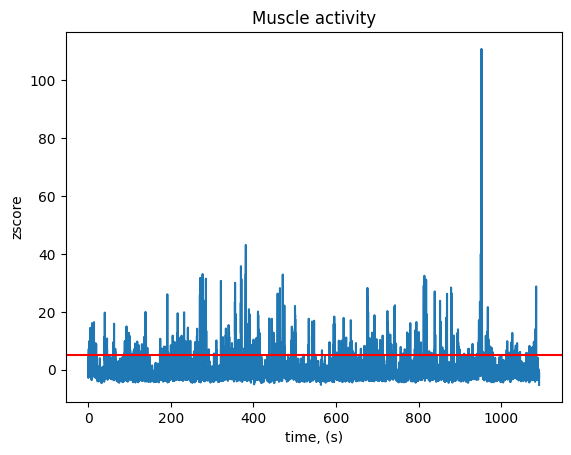

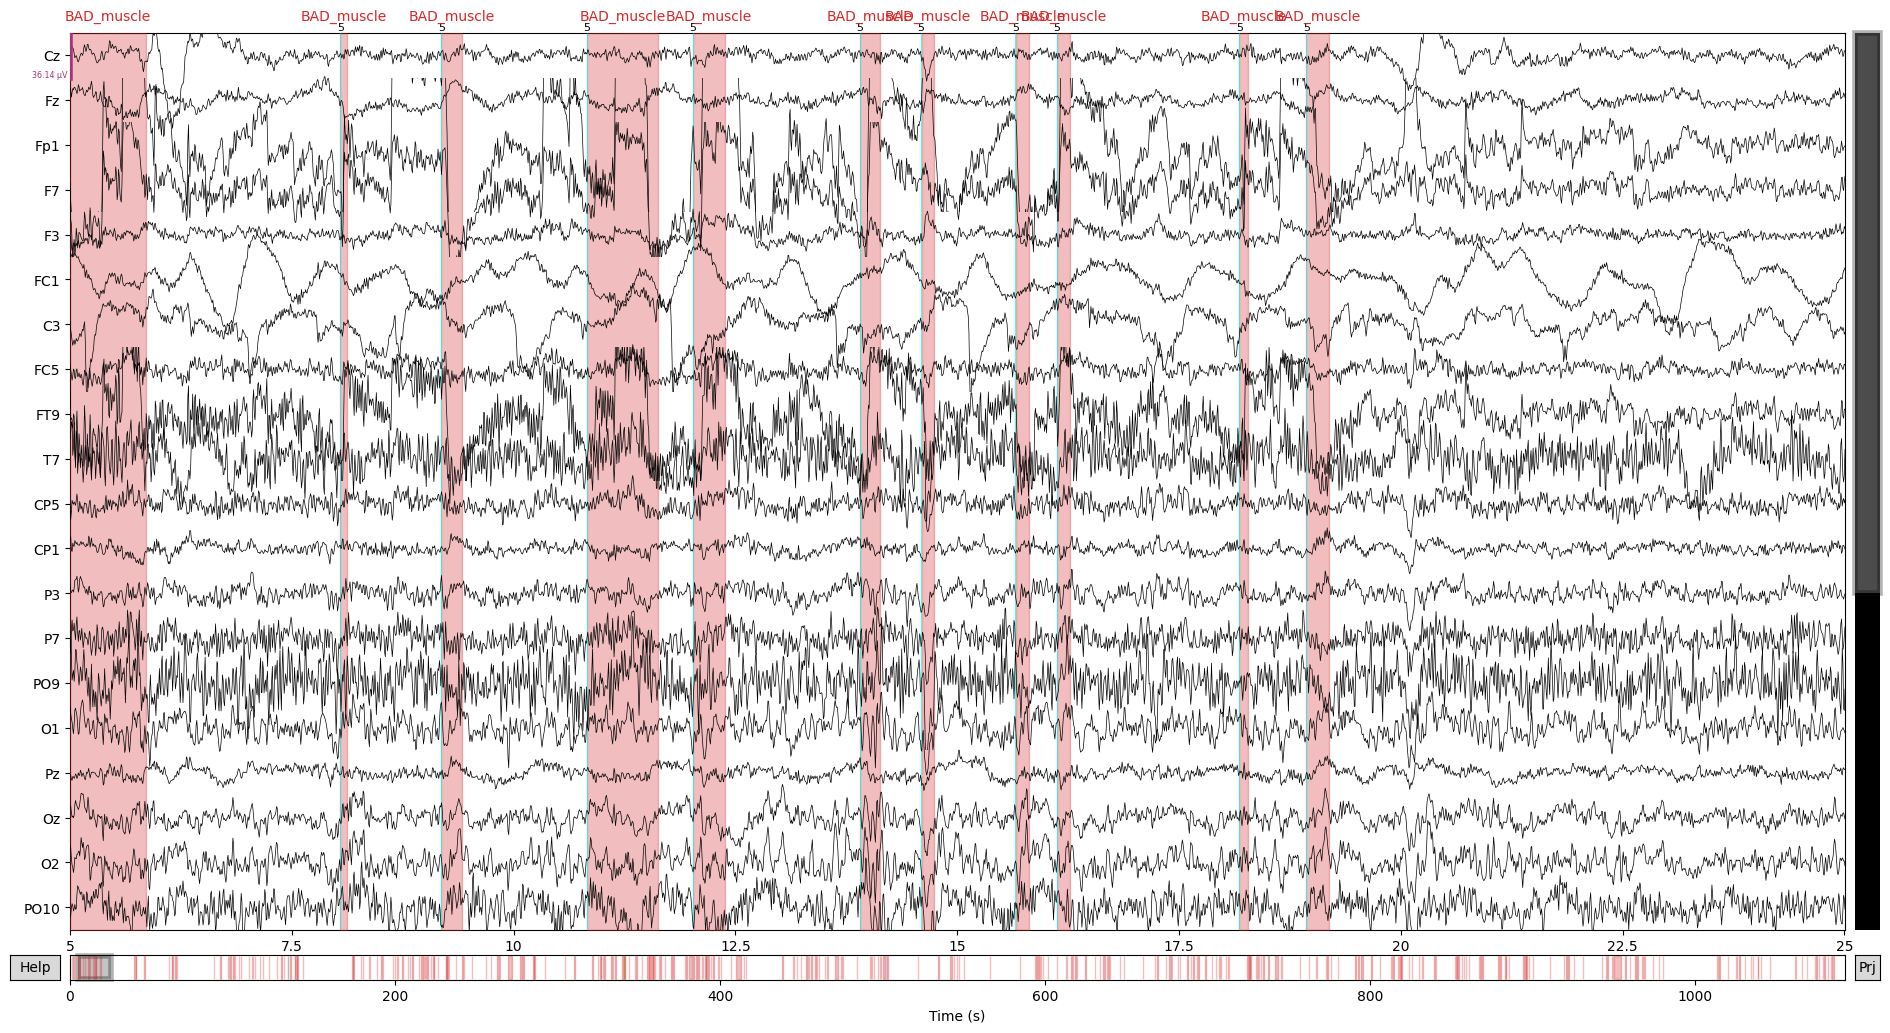

Plotted raw EEG data with annotations and events.


In [3]:
import mne
import numpy as np
import matplotlib.pyplot as plt

# Read your EDF file
raw = mne.io.read_raw_edf(r'EDF+\Zacker\Zacker.edf', preload=True)
print(f"Raw data loaded. Number of channels: {len(raw.ch_names)}, Sampling frequency: {raw.info['sfreq']} Hz")

# Select EEG channels
eeg_channels = ['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
raw.pick_channels(eeg_channels)
print(f"Selected EEG channels: {eeg_channels}")

# Set montage
montage = mne.channels.make_standard_montage('standard_1020')
raw.set_montage(montage, on_missing='ignore')
print("Standard 10-20 montage applied.")

# Apply preprocessing steps
raw.set_eeg_reference('average', projection=True)
raw.filter(l_freq=1, h_freq=40)
print("Applied average reference and band-pass filter (1 - 40 Hz).")

# Annotate muscle artifacts using z-score
threshold_muscle = 5  # z-score
annot_muscle, scores_muscle = mne.preprocessing.annotate_muscle_zscore(
    raw,
    ch_type="eeg",
    threshold=threshold_muscle,
    min_length_good=0.2,
    filter_freq=[1, 63],
)

# Print and plot muscle activity
fig, ax = plt.subplots()
ax.plot(raw.times, scores_muscle)
ax.axhline(y=threshold_muscle, color="r")
ax.set(xlabel="time, (s)", ylabel="zscore", title="Muscle activity")

# Define baseline period (0 to 30 seconds)
baseline_start = 0
baseline_end = 30
sfreq = raw.info['sfreq']  # Get the sampling frequency

# Extract baseline period
baseline_data, _ = raw[:, int(baseline_start * sfreq):int(baseline_end * sfreq)]

if annot_muscle is not None:
    # Combine annotations with merged events
    combined_annotations = annot_muscle.copy()  # Create a copy of muscle annotations
    raw.set_annotations(combined_annotations)
    print(f"Muscle artifacts annotated with z-score threshold={threshold_muscle}. Merged with video events.")

# Plot raw data with annotations
events_from_annot = mne.events_from_annotations(raw, event_id=None, regexp=None, use_rounding=False)[0]
order = np.arange(0, len(raw.ch_names))  # Replace with your valid channel indices
raw.plot(start=5, duration=20, order=order, title='Raw EEG Data with Annotations', scalings='auto', events=events_from_annot)

plt.show()

print("Plotted raw EEG data with annotations and events.")